# Фаза 2 • Неделя 8 • Четверг
## Нейронные сети
### 🔥 PyTorch: fine tuning

In [1]:
import kagglehub
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T
from torchvision import io
import torchutils as tu
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime


from torchvision.models import resnet50, ResNet50_Weights


/home/andrey/Documents/venv/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.__version__, torchvision.__version__)

2.6.0+cu124 0.21.0+cu124


In [3]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
#DEVICE = 'cpu'
print(DEVICE)

cuda:0


### Подготовка к работе

1. Загрузи этот ноутбук на Google Colab
2. Подгрузи архив [датасета](https://www.kaggle.com/datasets/ikobzev/architectural-heritage-elements-image64-dataset) в свое пространство и разархивируй его с помощью `unzip`. 

In [4]:
# Download latest version
#path = kagglehub.dataset_download("ikobzev/architectural-heritage-elements-image64-dataset")
#print("Path to dataset files:", path)

1. Убедись, что структура папок соответствует задаче классификации (либо приведите ее к формату, указанному ниже): 

        `train`
        
            - class_1
            - class_2
            - ...
            - class_n
            
        `valid`

            - class_1
            - class_2
            - ...
            - class_n

In [5]:
path0 = '/home/andrey/Documents/42 W8D4 Fine-Turning/data/'

2. Создай `DataLoader` в для обучающей и валидационных выборок. Примените аугментации к изображениям. 

In [6]:
transformer0 = T.Compose([
    #T.Resize((224, 224)), # проверить!
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor()
    ]
)

In [24]:
BATCH_SIZE = 256
train_dataset = torchvision.datasets.ImageFolder(path0 + 'train/', transform=transformer0)
valid_dataset = torchvision.datasets.ImageFolder(path0 + 'test/', transform=transformer0)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

3. Создай экземпляр предобученной модели: [torchvision models](https://pytorch.org/vision/stable/models.html). Можно взять любую модель для baseline, а дальше попробовать что-то более сложное. 

In [8]:
# Old weights with accuracy 76.130%
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

In [9]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

5. Замени выходной слой форматом, который подходит под задачу: бинарная или многоклассовая классификация. 

In [10]:
model.fc = nn.Linear(in_features=2048, out_features=10, bias=True)

In [11]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
# замораживаем все веса в модели
for param in model.parameters():
    param.requires_grad = False

model.fc.weight.requires_grad = True
model.fc.bias.requires_grad = True

model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [111]:
for p in model.parameters():
    print(p.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


In [15]:
tu.get_model_summary(model, torch.randn(BATCH_SIZE, 3, 64, 64, device=DEVICE))

Layer                                         Kernel               Output          Params             FLOPs
0_conv1                                      [3, 64, 7, 7]    [256, 64, 32, 32]       9,408   2,466,250,752
1_bn1                                                 [64]    [256, 64, 32, 32]         128      67,108,864
2_relu                                                   -    [256, 64, 32, 32]           0               0
3_maxpool                                                -    [256, 64, 16, 16]           0               0
4_layer1.0.Conv2d_conv1                     [64, 64, 1, 1]    [256, 64, 16, 16]       4,096     268,435,456
5_layer1.0.BatchNorm2d_bn1                            [64]    [256, 64, 16, 16]         128      16,777,216
6_layer1.0.ReLU_relu                                     -    [256, 64, 16, 16]           0               0
7_layer1.0.Conv2d_conv2                     [64, 64, 3, 3]    [256, 64, 16, 16]      36,864   2,415,919,104
8_layer1.0.BatchNorm2d_bn2  

6. Обучи модель (только последний слой!) и зафиксируй метрику на валидационной части выборки. 

In [16]:
def fit_model(
        model: torch.nn.Module, 
        n_epochs: int, 
        optimizer: torch.optim.Optimizer,
        train_loader: DataLoader,
        valid_loader: DataLoader
        ) -> tuple[list, ...]:
    """Function to fit model

    Returns:
        train_losses: list of train losses per epoch
        valid_losses: list of valid losses per epoch
        train_acc: list of train accuracy per epoch
        valid_acc: list of valid accuracy per epoch
    """
    train_losses = []
    valid_losses = []

    train_metric = []
    valid_metric = []
   
    for i in range(n_epochs):
        ####### ОБУЧЕНИЕ ##########
        model.train()

        train_loss_iter = []
        train_metric_iter = []

        valid_loss_iter = []
        valid_metric_iter = []
    
        for data, labels in train_loader:
            data = data.to(DEVICE)
            labels = labels.to(DEVICE)

            predictions = model(data)
            predictions = predictions.squeeze(-1)
            loss = criterion(predictions, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # потери в список
            train_loss_iter.append(loss.item())

            # метрика            
            train_metric_iter.append((predictions.cpu().argmax(axis=1) == labels.cpu()).numpy().mean())

        ###### ВАЛИДАЦИЯ ###########
        model.eval()
        for data, labels in valid_loader:
            with torch.no_grad():
                predictions = model(data.to(DEVICE))
            predictions = predictions.squeeze(-1)
            loss = criterion(predictions, labels.to(DEVICE))

            valid_loss_iter.append(loss.item())
            valid_metric_iter.append((predictions.cpu().argmax(axis=1) == labels.cpu()).numpy().mean())
            


        # после окончания эпохи запишем все усредненные характеристики в переменные 
        train_losses.append(np.mean(train_loss_iter))
        valid_losses.append(np.mean(valid_loss_iter))

        train_metric.append(np.mean(train_metric_iter))
        valid_metric.append(np.mean(valid_metric_iter))
        
        if i % 1 == 0:
            print(f'Epoch {i}: tr_loss={train_losses[-1]:.3f}, tr_acc={
                train_metric[-1]:.3f}, va_loss={valid_losses[-1]:.3f}, va_acc={valid_metric[-1]:.3f}')

    return model, train_losses, valid_losses, train_metric, valid_metric

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [23]:
start = datetime.datetime.now()
print('Время старта: ' + str(start))
model, train_losses, valid_losses, train_metric, valid_metric = fit_model(model=model, 
                                                                   n_epochs=30, 
                                                                   optimizer=optimizer,
                                                                   train_loader=train_loader,
                                                                   valid_loader=valid_loader
                                                                   )
#фиксируем и выводим время окончания работы кода
finish = datetime.datetime.now()
print('Время окончания: ' + str(finish))

# вычитаем время старта из времени окончания
print('Время : ' + str(finish - start))

Время старта: 2025-02-06 15:43:57.391571
Epoch 0: tr_loss=0.389, tr_acc=0.869, va_loss=0.851, va_acc=0.756
Epoch 1: tr_loss=0.405, tr_acc=0.864, va_loss=0.790, va_acc=0.789
Epoch 2: tr_loss=0.436, tr_acc=0.859, va_loss=0.991, va_acc=0.753
Epoch 3: tr_loss=0.436, tr_acc=0.861, va_loss=0.731, va_acc=0.792
Epoch 4: tr_loss=0.431, tr_acc=0.863, va_loss=0.928, va_acc=0.768
Epoch 5: tr_loss=0.435, tr_acc=0.858, va_loss=0.760, va_acc=0.793
Epoch 6: tr_loss=0.425, tr_acc=0.860, va_loss=0.861, va_acc=0.765
Epoch 7: tr_loss=0.392, tr_acc=0.871, va_loss=0.800, va_acc=0.764
Epoch 8: tr_loss=0.473, tr_acc=0.850, va_loss=1.043, va_acc=0.726
Epoch 9: tr_loss=0.487, tr_acc=0.843, va_loss=1.015, va_acc=0.745
Epoch 10: tr_loss=0.502, tr_acc=0.843, va_loss=0.928, va_acc=0.764
Epoch 11: tr_loss=0.455, tr_acc=0.855, va_loss=0.825, va_acc=0.776
Epoch 12: tr_loss=0.427, tr_acc=0.862, va_loss=0.939, va_acc=0.764
Epoch 13: tr_loss=0.413, tr_acc=0.866, va_loss=0.923, va_acc=0.763
Epoch 14: tr_loss=0.413, tr_acc

In [ ]:
#Epoch 89: tr_loss=0.469, tr_acc=0.856, va_loss=0.860, va_acc=0.775

7. Распечатай изображение из тестовой выборки и подпиши класс картинки, предсказанный моделью. 

In [66]:
#model.eval()
#model.to('cpu')
#output = model(batch[0].unsqueeze(0))
#_, predicted = torch.max(output.data, 1)
#int(predicted[0])

5

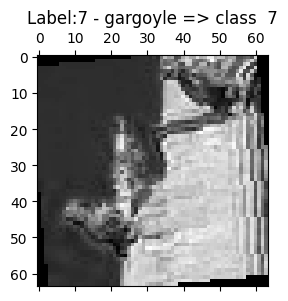

In [90]:
def get_batch_from_loader(loader):
    batch, labels = next(iter(loader))
    return batch, labels

model.eval()
model.to('cpu')

batch, labels = get_batch_from_loader(train_loader)
output = model(batch[0].unsqueeze(0))
_, predicted = torch.max(output.data, 1)


fig, ax = plt.subplots(1, 1, figsize=(3, 3))
#ax = ax.flatten()
ax.set_title(f'Label:{labels[0]} - {train_loader.dataset.classes[labels[0]]} => class  {(predicted[0])}')
ax.matshow(batch[0][0, :, :], cmap='gray')



8. "Разморозь" несоклько слоев базовой модели и вновь обучи ее. Зафиксируй метрику качества для модели. О том, как сделать unfreeze нескольких слоев сразу, а не только последнего, можно почитать тут: [discuss.pytorch.org](https://discuss.pytorch.org/t/how-the-pytorch-freeze-network-in-some-layers-only-the-rest-of-the-training/7088/3)

In [113]:
#model.named_children()

for name, child in model.layer4.named_children():
    for param in child.parameters():
        #print(param)
        #print(param.requires_grad)
        param.requires_grad = True


In [114]:
model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [115]:
for p in model.parameters():
    print(p.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [120]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [121]:
start = datetime.datetime.now()
print('Время старта: ' + str(start))
model, train_losses2, valid_losses2, train_metric2, valid_metric2 = fit_model(model=model, 
                                                                   n_epochs=30, 
                                                                   optimizer=optimizer,
                                                                   train_loader=train_loader,
                                                                   valid_loader=valid_loader
                                                                   )
#фиксируем и выводим время окончания работы кода
finish = datetime.datetime.now()
print('Время окончания: ' + str(finish))

# вычитаем время старта из времени окончания
print('Время : ' + str(finish - start))
#Epoch 59: tr_loss=0.014, tr_acc=0.995, va_loss=0.457, va_acc=0.916 lr=0.01
#Epoch 29: tr_loss=0.002, tr_acc=0.999, va_loss=0.497, va_acc=0.904 lr=0.001

Время старта: 2025-02-06 17:34:16.481310
Epoch 0: tr_loss=0.002, tr_acc=0.999, va_loss=0.582, va_acc=0.904
Epoch 1: tr_loss=0.002, tr_acc=0.999, va_loss=0.541, va_acc=0.917
Epoch 2: tr_loss=0.003, tr_acc=0.999, va_loss=0.554, va_acc=0.909
Epoch 3: tr_loss=0.001, tr_acc=0.999, va_loss=0.557, va_acc=0.914
Epoch 4: tr_loss=0.002, tr_acc=0.999, va_loss=0.522, va_acc=0.914
Epoch 5: tr_loss=0.001, tr_acc=0.999, va_loss=0.517, va_acc=0.914
Epoch 6: tr_loss=0.002, tr_acc=0.999, va_loss=0.524, va_acc=0.912
Epoch 7: tr_loss=0.001, tr_acc=1.000, va_loss=0.503, va_acc=0.914
Epoch 8: tr_loss=0.001, tr_acc=0.999, va_loss=0.506, va_acc=0.916
Epoch 9: tr_loss=0.001, tr_acc=0.999, va_loss=0.509, va_acc=0.915
Epoch 10: tr_loss=0.001, tr_acc=1.000, va_loss=0.529, va_acc=0.915
Epoch 11: tr_loss=0.001, tr_acc=1.000, va_loss=0.518, va_acc=0.904
Epoch 12: tr_loss=0.001, tr_acc=1.000, va_loss=0.519, va_acc=0.911
Epoch 13: tr_loss=0.001, tr_acc=1.000, va_loss=0.492, va_acc=0.922
Epoch 14: tr_loss=0.002, tr_acc

9. Сравни качество двух моделей: предобученной с замененным выходным слоем и дообученной с несколькими размороженными слоями. 

In [ ]:
# code

<img src="https://icons.iconarchive.com/icons/icons8/windows-8/256/Programming-Github-icon.png" width=32 /> Сохрани файл для __github__ и распечатай результат команды `!git status` в ячейке ниже. 

In [ ]:
# code

10. Сохрани модель (пример можно посмотреть [тут](../../learning/aux/model_saving.ipynb) или в [документации](https://pytorch.org/tutorials/beginner/saving_loading_models.html))

In [ ]:
# code

11. Реализуй функцию, которая на вход принимает путь к файлу, а в ответ возвращает класс объекта. 

In [1]:
def get_prediction(path: str) -> str:
    pass

12. Сохрани ноутбук на github